In [6]:
# Fixing pytube code from https://github.com/pytube/pytube/issues/2062
# Ignore this cell
import ssl
from pytube import YouTube
from pytube.innertube import _default_clients
from pytube.exceptions import RegexMatchError
import pytube
import re

_default_clients["ANDROID"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["ANDROID_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_MUSIC"]["context"]["client"]["clientVersion"] = "6.41"
_default_clients["ANDROID_MUSIC"] = _default_clients["ANDROID"]

def patched_get_throttling_function_name(js: str) -> str:
    function_patterns = [
        r'a\.[a-zA-Z]\s*&&\s*\([a-z]\s*=\s*a\.get\("n"\)\)\s*&&.*?\|\|\s*([a-z]+)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])?\([a-z]\)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])\([a-z]\)',
    ]
    for pattern in function_patterns:
        regex = re.compile(pattern)
        function_match = regex.search(js)
        if function_match:
            if len(function_match.groups()) == 1:
                return function_match.group(1)
            idx = function_match.group(2)
            if idx:
                idx = idx.strip("[]")
                array = re.search(
                    r'var {nfunc}\s*=\s*(\[.+?\]);'.format(
                        nfunc=re.escape(function_match.group(1))),
                    js
                )
                if array:
                    array = array.group(1).strip("[]").split(",")
                    array = [x.strip() for x in array]
                    return array[int(idx)]

    raise RegexMatchError(
        caller="get_throttling_function_name", pattern="multiple"
    )

ssl._create_default_https_context = ssl._create_unverified_context
pytube.cipher.get_throttling_function_name = patched_get_throttling_function_name

In [7]:
import cv2
import os
# Downloading video
YouTube('https://www.youtube.com/watch?v=l3NJNFmg09k').streams.first().download()

# Extracting images code from https://www.geeksforgeeks.org/extract-images-from-video-in-python/
# Read the video from specified path
cam = cv2.VideoCapture(os.path.abspath("Football match.mp4"))
try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')
currentframe = 0
while(True):
    # Reading a frame
    ret,frame = cam.read()
    # If there are frames left, generate another image
    if ret:
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)
        # Writing the extracted images
        cv2.imwrite(name, frame)
        currentframe += 1
    else:
        break
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr

In [8]:
# Source code from https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py
# See comments for important parts related to markdown cells
import warnings
from collections import OrderedDict
from typing import List, Optional, Tuple, Any
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.ops import MultiScaleRoIAlign

from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from torchvision.utils import _log_api_usage_once

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from PIL import Image
class GeneralizedRCNN(nn.Module):
    def __init__(self, backbone: nn.Module, rpn: nn.Module, roi_heads: nn.Module, transform: nn.Module) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.transform = transform
        self.backbone = backbone
        self.rpn = rpn
        self.roi_heads = roi_heads
        self._has_warned = False

    @torch.jit.unused
    def eager_outputs(self, losses, detections):
        if self.training:
            return losses

        return detections

    def forward(self, images, targets=None):
        if self.training:
            if targets is None:
                torch._assert(False, "targets should not be none when in training mode")
            else:
                for target in targets:
                    boxes = target["boxes"]
                    if isinstance(boxes, torch.Tensor):
                        torch._assert(
                            len(boxes.shape) == 2 and boxes.shape[-1] == 4,
                            f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.",
                        )
                    else:
                        torch._assert(False, f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
            )
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    torch._assert(
                        False,
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}.",
                    )
#------------------------------------------------------------------------------------------------------
# Pass the image through the backbone network to generate a feature map
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        print("Feature map shape: ", features["0"].shape)
#------------------------------------------------------------------------------------------------------
# Region proposal network:
# Run a sliding window through the feature map and generate anchors at each location
        proposals, proposal_losses = self.rpn(images, features, targets)
        print("Proposals shape: ", proposals[0].shape)
        print("Proposals generation: ")
        drawn_boxes = draw_bounding_boxes(torch.zeros(3,800,1280), proposals[0], colors="green")
        plt.imshow(drawn_boxes.permute(1, 2, 0))
#------------------------------------------------------------------------------------------------------
# ROI pooling and FC layers(classification and bounding box)
# Do ROI pooling to make all proposals the same size, then run them each through a classification and regression head
# This generates the predictions and bounding boxes
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return losses, detections
        else:
            return self.eager_outputs(losses, detections)

In [9]:
# Source code from https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py
# Ignore this cell, it just contains functions to initialize GeneralizedRCNN with specific parameters
def _default_anchorgen():
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    return AnchorGenerator(anchor_sizes, aspect_ratios)

class TwoMLPHead(nn.Module):
    def __init__(self, in_channels, representation_size):
        super().__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

_COMMON_META = {
    "categories": _COCO_CATEGORIES,
    "min_size": (1, 1),
}

class FasterRCNN_ResNet50_FPN_Weights(WeightsEnum):
    COCO_V1 = Weights(
        url="https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
        transforms=ObjectDetection,
        meta={
            **_COMMON_META,
            "num_params": 41755286,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/detection#faster-r-cnn-resnet-50-fpn",
            "_metrics": {
                "COCO-val2017": {
                    "box_map": 37.0,
                }
            },
            "_ops": 134.38,
            "_file_size": 159.743,
            "_docs": """These weights were produced by following a similar training recipe as on the paper.""",
        },
    )
    DEFAULT = COCO_V1

class FasterRCNN(GeneralizedRCNN):
    def __init__(
        self,
        backbone,
        num_classes=None,
        # transform parameters
        min_size=800,
        max_size=1333,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=10,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        **kwargs,
    ):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)"
            )

        if not isinstance(rpn_anchor_generator, (AnchorGenerator, type(None))):
            raise TypeError(
                f"rpn_anchor_generator should be of type AnchorGenerator or None instead of {type(rpn_anchor_generator)}"
            )
        if not isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None))):
            raise TypeError(
                f"box_roi_pool should be of type MultiScaleRoIAlign or None instead of {type(box_roi_pool)}"
            )

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            rpn_anchor_generator = _default_anchorgen()
        if rpn_head is None:
            rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            rpn_fg_iou_thresh,
            rpn_bg_iou_thresh,
            rpn_batch_size_per_image,
            rpn_positive_fraction,
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            rpn_nms_thresh,
            score_thresh=rpn_score_thresh,
        )

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(out_channels * resolution**2, representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(representation_size, num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
        )

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std, **kwargs)

        super().__init__(backbone, rpn, roi_heads, transform)

def fasterrcnn_resnet50_fpn(
    *,
    weights: Optional[FasterRCNN_ResNet50_FPN_Weights] = None,
    progress: bool = True,
    num_classes: Optional[int] = None,
    weights_backbone: Optional[ResNet50_Weights] = ResNet50_Weights.IMAGENET1K_V1,
    trainable_backbone_layers: Optional[int] = None,
    **kwargs: Any,
) -> FasterRCNN:
    weights = FasterRCNN_ResNet50_FPN_Weights.verify(weights)
    weights_backbone = ResNet50_Weights.verify(weights_backbone)

    if weights is not None:
        weights_backbone = None
        num_classes = _ovewrite_value_param("num_classes", num_classes, len(weights.meta["categories"]))
    elif num_classes is None:
        num_classes = 91

    is_trained = weights is not None or weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained, trainable_backbone_layers, 5, 3)
    norm_layer = misc_nn_ops.FrozenBatchNorm2d if is_trained else nn.BatchNorm2d

    backbone = resnet50(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    model = FasterRCNN(backbone, num_classes=num_classes, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))
        if weights == FasterRCNN_ResNet50_FPN_Weights.COCO_V1:
            overwrite_eps(model, 0.0)

    return model

Feature map shape:  torch.Size([1, 1280, 24, 42])
Proposals shape:  torch.Size([888, 4])
Proposals generation: 


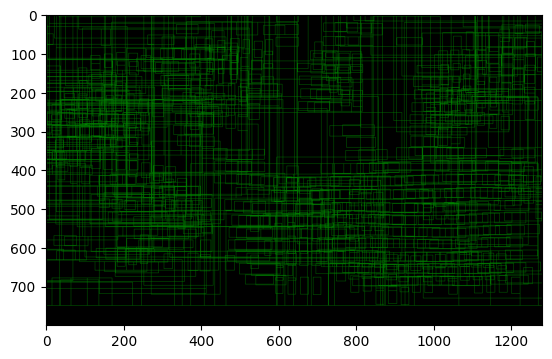

In [12]:
# Showing the first steps of Faster RCNN(untrained): proposal generation
backbone = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler, box_detections_per_img=20)
# Output comes from added code to the GeneralizedRCNN class
model.eval()
test_img = Image.open('data/frame0.jpg')
transform = transforms.Compose([
    transforms.ToTensor(),
])
test_img = transform(test_img)
x = [test_img]
predictions = model(x)

<b>Proposal Generation Method</b><br>
The first step of Faster RCNN is to pass the image through a backbone such as mobilenet_v2. Mobilenet_v2 is a CNN that we use to create a feature map. Unlike Fast RCNN where proposals are generated by moving a sliding window across the height and width of the image to produce different crops which are fed to a CNN, Faster RCNN first passes the image through the backbone to create a feature map, greatly reducing the height and width the sliding window has to go through.
<br><b>Region Proposal Network(RPN)</b><br>
At the center of each sliding window, Faster RCNN generates anchors, which are boxes of different sizes and aspect ratios, to capture objects with varying shape. The RPN then determines whether the anchor contains an object is background, defined as objectness and is trained to produce anchors that are closer to the ground truth bounding boxes. The generated proposals for an untrained model are displayed above(imagine the image as a feature map).

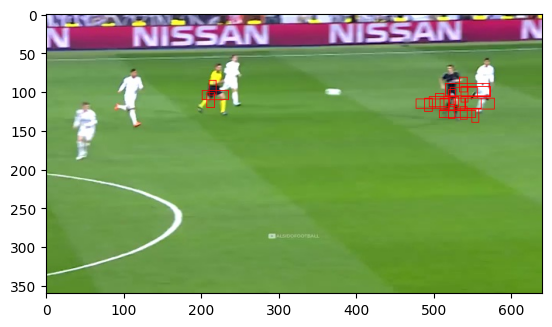

In [13]:
drawn_boxes = draw_bounding_boxes(x[0], predictions[0]["boxes"], colors="red")
plt.imshow(drawn_boxes.permute(1, 2, 0))

<b>Region of Interest(ROI) Pooling and FC Layer(classification and bounding box)</b><br>
After the proposals/anchors have been generated, Faster RCNN must classify each object and determine the bounding box for it. Since anchors are of different sizes, and a network expects a fixed size, ROI pooling is done to make them all the same size. This is done by splitting the image into a number of sections, then doing max pooling on each section. These resized proposals can then be fed through a classification and regression head(additional CNN layers for each head) to produce the object class and bounding box respectively. These additional layers also have to be trained separate from the RPN or jointly. The output bounding boxes for an untrained model are shown above.

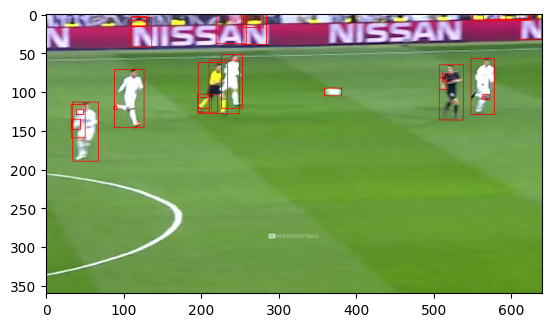

In [14]:
# Using a pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
model.eval()
predictions = model(x)
drawn_boxes = draw_bounding_boxes(x[0], predictions[0]["boxes"], colors="red")
plt.imshow(drawn_boxes.permute(1, 2, 0))

With Faster RCNN explained, the next step is to train the model. Since this can take hours or days, instead pretrained weights from the COCO model will be used. As shown in the image above, the model is able to detect the players and ball relatively accurately.

In [ ]:
# Since the model works for a single image, it will now be used on each frame of the video
# Note no Kalman filters or object tracking will be used here. Also I process an image at a time to save RAM
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
])
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
model.eval()
for i in range(1074):
    image = Image.open(f'data/frame{i}.jpg')
    image = transform(image)
    predictions = model([image])
    drawn_boxes = draw_bounding_boxes(image, predictions[0]["boxes"], colors="red")
    torchvision.utils.save_image(drawn_boxes, f'results/frame{i}.jpg')

In [ ]:
# Creating a video from the results
frame = cv2.imread('results/frame0.jpg')
height, width, layers = frame.shape
video = cv2.VideoWriter('ObjectTracking.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 25.0, (width, height))
for i in range(1074):
    video.write(cv2.imread(f'results/frame{i}.jpg'))
video.release()
cv2.destroyAllWindows()